# A Hybrid Learning Approach to Generating Synthetic Positions for Tax Loss Harvesting

## Generation of Synthetic Positions Using Hybrid Learning

In [99]:
def hybrid_learning_replace(ticker) -> {}:
    """Determines which stocks to buy to emulate the performance of another
    :param ticker: The stock for which a synthetic position should be calculated
    :returns replacement_stocks: Dictionary of replacements stock tickers and their quantities
    """
    return {}
    #TODO

# Stock Market Backtester

In [100]:
import pandas as pd
import yfinance as yf
import pyfolio as pf #install using  pip3 install git+https://github.com/quantopian/pyfolio
from enum import Enum
import warnings
%matplotlib inline

In [101]:
start_date = "2012-09-16" #TODO choose real start date
end_date = "2013-01-10" #TODO choose real end date
all_tickers = ['SPY', 'AAPL'] #TODO make list of real tickers

# Price history downloaded from Yahoo Finance
price_history = {}
for symbol in all_tickers:
    price_history[symbol] = yf.Ticker(symbol).history(start = start_date, end = end_date)

# Gets a list of all valid trading dates
all_dates = price_history[all_tickers[0]].axes[0].values
dates = pd.DatetimeIndex(data = all_dates)
current_date = all_dates[0]

In [102]:
def get_stock_price(ticker, day, time) -> float:
    """Retrieves the closing price of a stock on a given date
    :param ticker: stock for which to retrieve the value
    :param day: date on which to retrieve the value
    :param time of day to calculate the value, either Time.OPEN or Time.CLOSE
    """
    if time==Time.OPEN:
        return round(price_history[ticker].Open[day], 2)
    elif time==Time.CLOSE:
        return round(price_history[ticker].Close[day], 2)

class Time(Enum):
    OPEN = 0
    CLOSE = 1

class Stock:
    def __init__(self, ticker, quantity=0):
        """Creates an object representing an owned stock
        :param ticker: The stock's ticker symbol
        :param quantity: How much of this stock is owned (this should only be used when constructing initial stock portfolios, as it essentially creates stock for free)
        """
        self.ticker = ticker
        self.quantity = quantity
        self.avg_cost = get_stock_price(self.ticker, current_date, Time.CLOSE)

    def buy(self, quantity, day_price):
        """Simulates a portfolio acquiring new stock
        :param quantity: The amount of new stock to acquire
        :param day_price: The price of the stock on the day of acquisition
        """
        previously_owned = self.quantity
        self.quantity += quantity
        self.avg_cost += (previously_owned*self.avg_cost + quantity*day_price)/self.quantity

    def sell(self, quantity, day_price):
        """Simulates a portfolio selling a stock
        :param quantity: The amount of new stock to sell
        :param day_price: The price of the stock on the day of acquisition
        """
        previously_owned = self.quantity
        self.quantity -= quantity
        self.avg_cost -= (previously_owned*self.avg_cost - quantity*day_price)/self.quantity

    def sell_all(self):
        """Simulates selling all of a stock
        """
        self.quantity = 0
        self.avg_cost = 0
        
    def get_pct_change(self):
        """Gets the percent change of the stock based on the average cost
        """
        change = self.get_change()
        return 100*(change/self.avg_cost)

    def get_change(self) -> float:
        """Gets the difference between the stock's average purchase price and its current price
        :returns change: float
        """
        current_price = get_stock_price(self.ticker, current_date, Time.CLOSE)
        return current_price - self.avg_cost

        

class Portfolio:
    def __init__(self, starting_cash_balance: float = 1000000, starting_stocks=None):
        """Creates a new portfolio
        :param starting_cash_balance: The amount of cash the portfolio should start with (default 100,000.0)
        :param starting_stocks: A dictionary containing the stocks the portfolio should begin with {'Ticker': Stock Object} (default is no starting stocks)
        """
        if starting_stocks is None:
            starting_stocks = {}
        self.stocks = starting_stocks
        self.cash_balance = starting_cash_balance
        self.value = 0
        self.calculate_value(Time.CLOSE)
        self.closing_prices = []
        self.returns = None
        self.wash_sale_list = {}

    def calculate_value(self, time):
        """Calculates the value of the portfolio based on the close of the global current date
        :param time of day to calculate the value, either Time.OPEN or Time.CLOSE
        """
        self.calculate_value_date(current_date, time)

    def calculate_value_date(self, day, time):
        """Calculates the value of the portfolio based on a specified date
        :param day: the date on which the portfolio's value should be calculated
        :param time of day to calculate the value, either Time.OPEN or Time.CLOSE
        """
        self.value = self.cash_balance
        for stock in self.stocks.keys():
            self.value += get_stock_price(stock, day, time) * self.stocks[stock].quantity

    def update_wash_sale_list(self):
        """Increments the counter for every item in the wash sale list and removes an item if the counter is >30
        """
        remove_from_list = []
        for wash_stock in self.wash_sale_list.keys():
            self.wash_sale_list[wash_stock] += 1
            if self.wash_sale_list[wash_stock] > 30:
                remove_from_list.append(wash_stock)

        for to_remove in remove_from_list:
            self.wash_sale_list.pop(to_remove)

    def begin_day(self):
        """Calculates the starting value of the day and updates the wash sale list"""
        self.calculate_value(Time.CLOSE)
        self.update_wash_sale_list()

    def end_day(self):
        """"Calculates the day's closing value and adds it to a list
        """
        self.calculate_value(Time.CLOSE)
        self.closing_prices.append(self.value)

    def end_simulation(self):
        """Creates a Pandas Series of percent change of closing values and returns it
        """
        self.returns = pd.Series(data = self.closing_prices, index = dates).pct_change()
        return self.returns

    def does_own_stock(self, ticker) -> bool:
        """Reports whether or not this portfolio contains a given stock
        :param ticker: The stock to search for
        """
        return ticker in self.stocks.keys()

    def buy_stock(self, ticker, quantity):
        """Buys stock using cash balance if possible
        :param ticker: The stock to purchase
        :param quantity: The quantity of the stock to purchase (can be a float)
        """
        stock_price = get_stock_price(ticker, current_date, Time.CLOSE)
        trade_basis = stock_price*quantity #TODO can add fees here

        # Exit if we cannot complete the trade
        if trade_basis>self.cash_balance:
            warnings.warn("Not enough cash to execute trade: buy "+str(quantity)+ " " + ticker)
            return
        
        if ticker in self.wash_sale_list:
            warnings.warn("Cannot buy "+ticker+": wash sale violation")
            return

        # If we do not currently own the stock, create an entry
        if ticker not in self.stocks.keys():
            self.stocks[ticker] = Stock(ticker)

        # Execute the trade
        self.stocks[ticker].buy(quantity, stock_price)
        self.cash_balance -= trade_basis

    def sell_stock(self, ticker, quantity = 0, sell_all = False):
        """Sells stock and adds to cash balance
        :param ticker: The stock to sell
        :param quantity: The quantity of the stock to sell (can be a float)
        :param sell_all: Optional parameter to sell all stock
        """
        stock_price = get_stock_price(ticker, current_date, Time.CLOSE)
        # Ensure we have enough stock to sell
        quantity_owned = self.stocks[ticker].quantity
        if quantity > quantity_owned:
            return


        if sell_all or quantity==quantity_owned:
            self.stocks[ticker].sell_all()
            self.cash_balance += quantity_owned*stock_price
            self.stocks.pop(ticker)

            # Update the wash sale list
            self.wash_sale_list[ticker] = 0
            return

        # Do the trade
        self.stocks[ticker].sell()
        self.cash_balance += quantity*stock_price #TODO maybe things should be added to the wash sale list even if we just sell partial (but in theory we are always doing sellall)
    
    def identify_losers(self):
        """Identifies stocks that have dropped in value more than 5% since they were bought
        :returns identified_losers: List of all stocks that have dropped more than 5%
        """
        identified_losers = []
        for owned_stock in self.stocks.keys():
            if self.stocks[owned_stock].get_change()<= -1*(0.05*self.value):
                identified_losers.append(owned_stock)
        return identified_losers


In [103]:
# The hybrid learning portfolio
h_l_portfolio = Portfolio(0, {'AAPL': Stock('AAPL', 1)}) #TODO define large array of starting stocks that every portfolio should start with

for date in all_dates:
    # update the current day
    current_date = date

    # Allow the portfolio to perform start of day updates
    h_l_portfolio.begin_day()

    # Determine which stocks should be tax loss harvested
    losers = h_l_portfolio.identify_losers()
    
    for losing_stock in losers:
        # Get dictionary of replacement stocks {'Ticker': Quantity}
        replacement_stocks = hybrid_learning_replace(losing_stock)

        # Sell the losing stock
        h_l_portfolio.sell_stock(losing_stock, sell_all=True)

        # Buy the replacement stocks
        for buy_stock in replacement_stocks.keys():
            h_l_portfolio.buy_stock(buy_stock, replacement_stocks[buy_stock])

    # Allow the portfolio to perform end-of-day updates
    h_l_portfolio.end_day()

# Inform the portfolio that the simulation has ended
returns = h_l_portfolio.end_simulation()
print(returns)
print(h_l_portfolio.value)


selin
2012-09-17         NaN
2012-09-18    0.003262
2012-09-19    0.000000
2012-09-20   -0.004645
2012-09-21    0.001867
                ...   
2013-01-03    0.000000
2013-01-04    0.000000
2013-01-07    0.000000
2013-01-08    0.000000
2013-01-09    0.000000
Length: 78, dtype: float64
20.4


/Users/nikhil/Documents/Finance Research/A-Hybrid-Learning-Approach-to-Generating-Synthetic-Positions-for-Tax-Loss-Harvesting/venv/lib/python3.10/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2012-09-17
End date,2013-01-09
Total months,3
,Backtest
Annual return,-15.097%
Cumulative returns,-4.939%
Annual volatility,5.602%
Sharpe ratio,-2.93
Calmar ratio,-2.88
Stability,0.20
Max drawdown,-5.248%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.25,2012-09-19,2012-09-26,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


/Users/nikhil/Documents/Finance Research/A-Hybrid-Learning-Approach-to-Generating-Synthetic-Positions-for-Tax-Loss-Harvesting/venv/lib/python3.10/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/nikhil/Documents/Finance Research/A-Hybrid-Learning-Approach-to-Generating-Synthetic-Positions-for-Tax-Loss-Harvesting/venv/lib/python3.10/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/nikhil/Documents/Finance Research/A-Hybrid-Learning-Approach-to-Generating-Synthetic-Positions-for-Tax-Loss-Harvesting/venv/lib/python3.10/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will 

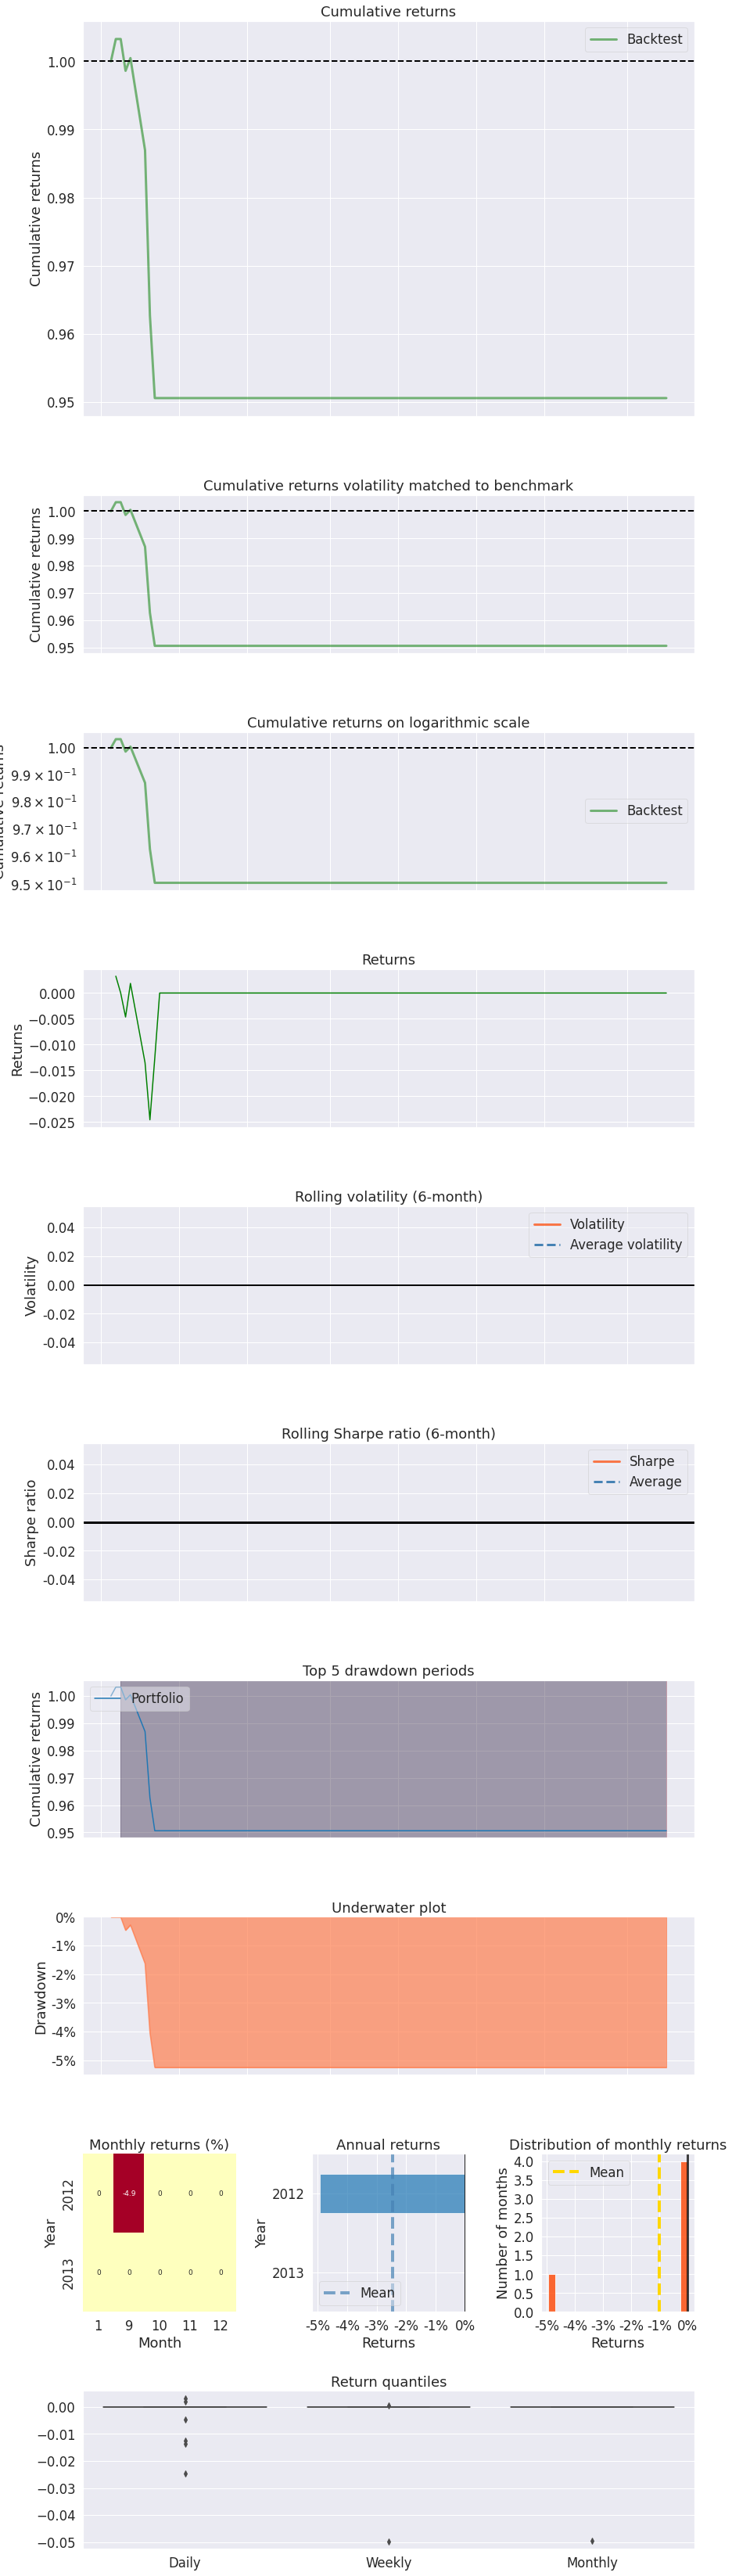

In [104]:
pf.create_returns_tear_sheet(returns)